# Data download

In [1]:
!wget https://zenodo.org/record/15548394/files/chronorhetorics-corpus-v1.0-all.zip

--2026-01-25 13:28:18--  https://zenodo.org/record/15548394/files/chronorhetorics-corpus-v1.0-all.zip
Resolving zenodo.org (zenodo.org)... 188.185.43.153, 188.185.48.75, 137.138.52.235, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.153|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/15548394/files/chronorhetorics-corpus-v1.0-all.zip [following]
--2026-01-25 13:28:19--  https://zenodo.org/records/15548394/files/chronorhetorics-corpus-v1.0-all.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 1410789198 (1.3G) [application/octet-stream]
Saving to: ‘chronorhetorics-corpus-v1.0-all.zip’

chronorhetorics-cor 100%[===================>]   1.31G  2.74MB/s    in 8m 9s   

2026-01-25 13:36:28 (2.75 MB/s) - ‘chronorhetorics-corpus-v1.0-all.zip’ saved [1410789198/1410789198]



In [2]:
!unzip chronorhetorics-corpus-v1.0-all.zip -d corpus_data

Streaming output truncated to the last 5000 lines.
  inflating: corpus_data/data/institution/ru-putin-speeches/RU-Kremlin-Putin-Transcripts-13365.json  
  inflating: corpus_data/data/institution/ru-putin-speeches/RU-Kremlin-Putin-Transcripts-11358.json  
  inflating: corpus_data/data/institution/ru-putin-speeches/RU-Kremlin-Putin-Transcripts-32438.json  
  inflating: corpus_data/data/institution/ru-putin-speeches/RU-Kremlin-Putin-Transcripts-19768.json  
  inflating: corpus_data/data/institution/ru-putin-speeches/RU-Kremlin-Putin-Transcripts-4537.json  
  inflating: corpus_data/data/institution/ru-putin-speeches/RU-Kremlin-Putin-Transcripts-30405.json  
  inflating: corpus_data/data/institution/ru-putin-speeches/RU-Kremlin-Putin-Transcripts-29624.json  
  inflating: corpus_data/data/institution/ru-putin-speeches/RU-Kremlin-Putin-Transcripts-0827.json  
  inflating: corpus_data/data/institution/ru-putin-speeches/RU-Kremlin-Putin-Transcripts-1735.json  
  inflating: corpus_data/data/inst

In [3]:
ls -1 corpus_data/data/institution/ru-putin-speeches/ | wc -l

33129


In [ ]:
cat corpus_data/data/institution/ru-putin-speeches/RU-Kremlin-Putin-Transcripts-8827.json

{
  "id": "RU-Kremlin-Putin-Transcripts-8827",
  "url": "http://en.kremlin.ru/events/president/news/37696",
  "title": "Russian-Chinese talks have confirmed the strategic nature of the two country's bilateral relations",
  "language": "en",
  "date": "2007-03-26",
  "date_iso": "2007-03-26T17:46:00",
  "source_type": "Institution",
  "source_name": "Kremlin",
  "location": "",
  "structured_content": [
    {
      "type": "report",
      "sequence": 1,
      "speaker": "KREMLIN",
      "text": "The Russian and Chinese leaders met six times in 2006, President Vladimir Putin said following a meeting with President of the People’s Republic of China Hu Jintao, in Russia on a state visit. Mr Putin and Mr Hu discussed top issues currently on the international and bilateral agendas. Russia and China intend to continue developing joint projects and expand their partnership in all areas. The two Presidents discussed specific steps to develop cooperation, which are reflected in the Joint Declara

# json analysis

In [4]:
import os
import json
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

plt.rcParams["figure.figsize"] = (10, 5)

BASE_PATH = "/content/corpus_data/data/institution/ru-putin-speeches"

files = sorted(os.listdir(BASE_PATH))

records = []
all_text = []

for fname in files:
    with open(os.path.join(BASE_PATH, fname), encoding="utf-8") as f:
        data = json.load(f)

        records.append({
            "id": data.get("id"),
            "date": data.get("date"),
            "language": data.get("language"),
            "title": data.get("title"),
            "num_blocks": len(data.get("structured_content", []))
        })

        for block in data.get("structured_content", []):
            all_text.append(block.get("text", ""))

df = pd.DataFrame(records)

print("Number of docs:", len(df))
print("\languages:")
print(df["language"].value_counts())


<>:35: SyntaxWarning: invalid escape sequence '\l'
<>:35: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-2971885074.py:35: SyntaxWarning: invalid escape sequence '\l'
  print("\languages:")


Number of docs: 33129
\languages:
language
en    33129
Name: count, dtype: int64


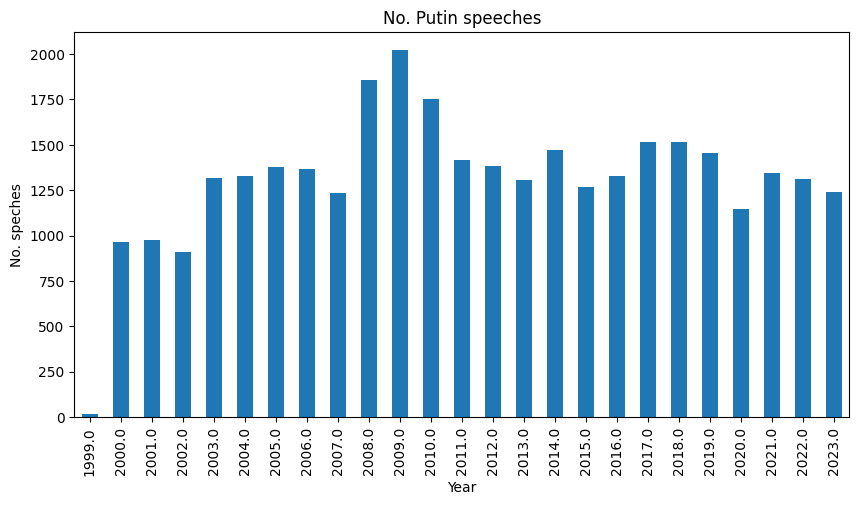

In [5]:
df["year"] = pd.to_datetime(df["date"], errors="coerce").dt.year

year_counts = df["year"].value_counts().sort_index()

year_counts.plot(kind="bar")
plt.title("No. Putin speeches")
plt.xlabel("Year")
plt.ylabel("No. speches")
plt.show()


# Creating BERT ready file - preprocessing

In [6]:
import os
import json
import pandas as pd

BASE_PATH = "corpus_data/data/institution/ru-putin-speeches"
TARGET_SPEAKERS = {"PRESIDENT PUTIN", "VLADIMIR PUTIN"}

corpus_data = []

# files processing

for root, dirs, files in os.walk(BASE_PATH):
    for file in files:
        if file.endswith(".json"):
            path = os.path.join(root, file)
            try:
                with open(path, encoding="utf-8") as f:
                    data = json.load(f)

                doc_speaker = data.get("speaker")
                structured_content = data.get("structured_content", [])

                for block in structured_content:
                    # speaker
                    current_speaker = block.get("speaker", doc_speaker)

                    if current_speaker in TARGET_SPEAKERS:
                        text_content = block.get("text") or block.get("content")
                        if text_content and isinstance(text_content, str):
                            corpus_data.append({
                                "text": text_content.strip(),
                                "speaker": current_speaker,
                                "source_file": file
                            })

            except Exception as e:
                print(f"Błąd przy pliku {file}: {e}")
                continue

df = pd.DataFrame(corpus_data)
# removing 0 length speeches
df = df[df["text"].str.len() > 0].reset_index(drop=True)

print(f"Zakończono. Zebrano {len(df)} wypowiedzi.")
print("-" * 30)
print(df.head())
df.to_csv("putin_speeches_bert_ready.csv", index=False)

Rozpoczynam przetwarzanie plików...
Zakończono. Zebrano 30024 wypowiedzi.
------------------------------
                                                text          speaker  \
0  Dear friends, colleagues, ladies and gentlemen...  PRESIDENT PUTIN   
1  Did you just discuss the issue or did you reac...  PRESIDENT PUTIN   
2  You will recall that we met recently with bank...  PRESIDENT PUTIN   
3  Regarding the Treasury's surplus funds: what d...  PRESIDENT PUTIN   
4  I hope that the Government's decree on the usa...  PRESIDENT PUTIN   

                               source_file  
0  RU-Kremlin-Putin-Transcripts-24239.json  
1  RU-Kremlin-Putin-Transcripts-10037.json  
2  RU-Kremlin-Putin-Transcripts-10037.json  
3  RU-Kremlin-Putin-Transcripts-10037.json  
4  RU-Kremlin-Putin-Transcripts-10037.json  


## Tokenization

In [7]:
##### RUN BERT Tokenizer

from transformers import AutoTokenizer

MODEL_NAME = "DeepPavlov/rubert-base-cased"
print(f"\Loading tokenizer: {MODEL_NAME}...")
try:
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

    # example
    sample_text = df["text"].iloc[0]

    encoded_input = tokenizer(
        sample_text,
        padding="max_length",
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )

    print("\nPrzykład tekstu:", sample_text[:100], "...")
    print("Tokeny (Input IDs):", encoded_input["input_ids"])
    print("Format gotowy do modelu!")

except Exception as e:
    print("no transformers and torch.")


Ładowanie tokenizera: DeepPavlov/rubert-base-cased...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]


Przykład tekstu: Dear friends, colleagues, ladies and gentlemen, I would like to congratulate you on Russia Day. This ...
Tokeny (Input IDs): tensor([[   101,  52067,  35862,  50842,    128,  13190,   7159,  52890,    269,
            128,  10621,  20507,    269,  10623,  15843,    271,  19855,   4305,
            128,    186,  13308,  43677,  12362,  10626,  10685,  53678,  19515,
          17210,    241,  13540,  10647,  15176,  12872,    132,  11259,  13685,
          10902,  25070,  29733,    269,  10617,  33394,  13603,   4388,    130,
          13410,    128,  10631, 114205,  47303,   7491,  20706,    247,  10037,
          17958,  26862,  11592,    158,  17958,  14133,  12436,  16217,  50008,
          10623,  14468,  14347,  68750,    158,  10617,  24621,  11756,  10725,
            255,    128,  92635,  46034,  17269,  50754,  28668,  24627,  10623,
          10617,  10743,  11052,   7729,  11796,  96614,  10626,  11263,  10773,
         103949,  10037,  10616,  48892,  10938

# text to chunks

In [8]:
import torch
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
import os
import json

# Configuration
BASE_PATH = "corpus_data/data/institution/ru-putin-speeches"
TARGET_SPEAKERS = {"PRESIDENT PUTIN", "VLADIMIR PUTIN"}
# Using a lighter, English-optimized model for embeddings
EMBEDDING_MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"

# ---------------------------------------------------------
# STEP 1: LOAD AND FILTER DATA
# ---------------------------------------------------------

corpus_data = []
print("Loading corpus data files...")

for root, dirs, files in os.walk(BASE_PATH):
    for file in files:
        if file.endswith(".json"):
            path = os.path.join(root, file)
            try:
                with open(path, encoding="utf-8") as f:
                    data = json.load(f)

                doc_speaker = data.get("speaker")
                structured_content = data.get("structured_content", [])

                # Structured content (blocks)
                for block in structured_content:
                    current_speaker = block.get("speaker", doc_speaker)

                    if current_speaker in TARGET_SPEAKERS:
                        text_content = block.get("text") or block.get("content")

                        if text_content and isinstance(text_content, str):
                            corpus_data.append({
                                "text": text_content.strip(),
                                "speaker": current_speaker,
                                "source_file": file
                            })

            except Exception as e:
                print(f"Error reading file {file}: {e}")
                continue

df = pd.DataFrame(corpus_data)

# Remove empty speeches
if not df.empty:
    df = df[df["text"].str.len() > 0].reset_index(drop=True)
else:
    print("Warning: No data found matching the speaker criteria.")

print(f"Done. Collected {len(df)} speeches.")
print("-" * 30)

# ---------------------------------------------------------
# STEP 2: CHUNKING (SPLITTING TEXT)
# ---------------------------------------------------------

def chunk_text(text, chunk_size=800, overlap=100):
    """Splits long text into smaller chunks for the model."""
    chunks = []
    start = 0
    while start < len(text):
        end = start + chunk_size
        chunks.append(text[start:end])
        start += chunk_size - overlap
    return chunks

print("Splitting text into chunks...")
documents = []
for _, row in df.iterrows():
    chunks = chunk_text(row['text'])
    for chunk in chunks:
        documents.append({
            "text": chunk,
            "source": row['source_file']
        })

doc_df = pd.DataFrame(documents)
print(f"Created {len(doc_df)} text chunks ready for the database.")


Loading corpus data files...
Done. Collected 30024 speeches.
------------------------------
Splitting text into chunks...
Created 82266 text chunks ready for the database.


# Questions:
- In what context does “Poland” most often appear? (enemy, partner, ally, neighbor)
- How does he construct the image of the “enemy”? (Topic modeling + embedding clustering, BERTopic / Sentence-BERT)
- When do numerous references to the “Russian world” (russkiy mir) begin to appear? (Keyword frequency over time + NER, spaCy / HuggingFace NER)
- Provide quotes where he describes Poland in historical terms. (Keyword search + NER + sentence extraction, spaCy / Regex)
- Has Putin ever said about event Z

/tmp/ipython-input-2866661124.py:7: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  poland_chunks = doc_df[doc_df['text'].str.contains(r'\bPol(and|ish)\b', case=False, regex=True)].copy()


Znaleziono 389 fragmentów dotyczących Polski.


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cuda:0


Klasyfikacja kontekstu (to może chwilę potrwać)...


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



Wyniki analizy kontekstu dla 'Poland':
context
partner     131
neighbor    127
ally        111
enemy        20
Name: count, dtype: int64


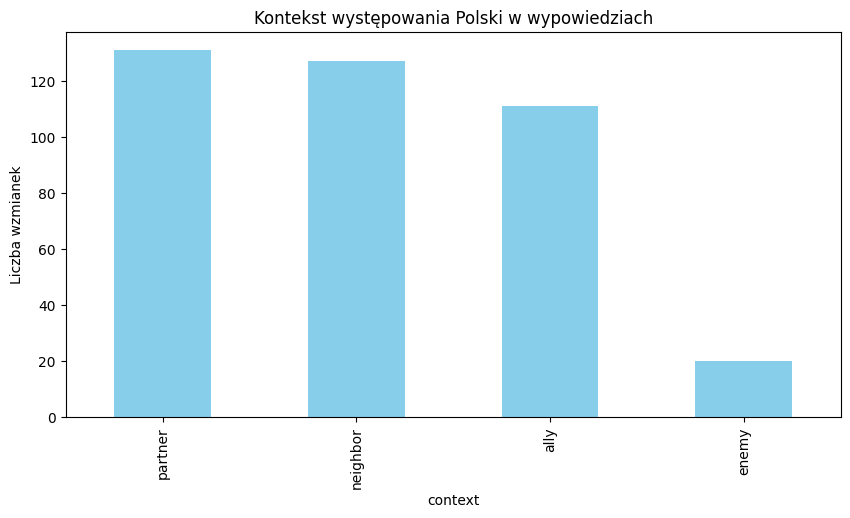

In [9]:
import pandas as pd
from transformers import pipeline
import matplotlib.pyplot as plt

# 1. Filtering Polish quotes
# regex looks for "Poland", "polish etc"
poland_chunks = doc_df[doc_df['text'].str.contains(r'\bPol(and|ish)\b', case=False, regex=True)].copy()

print(f"Found {len(poland_chunks)} texts related to Poland.")

if not poland_chunks.empty:
    # 2. Zero-Shot classiffier initialization
    classifier = pipeline("zero-shot-classification",
                          model="facebook/bart-large-mnli",
                          device=0 if torch.cuda.is_available() else -1)

    candidate_labels = ["enemy", "partner", "ally", "neighbor"]

    # 3. Classification of each label
    def classify_context(text):
        results = classifier(text, candidate_labels)
        return results['labels'][0]  # Returns label with highest score

    print("Classifing....")
    poland_chunks['context'] = poland_chunks['text'].apply(classify_context)

    # 4. Scores aggregation
    results_summary = poland_chunks['context'].value_counts()
    print("\nWyniki analizy kontekstu dla 'Poland':")
    print(results_summary)

    # Visualization
    results_summary.plot(kind='bar', color='skyblue')
    plt.title("Kontekst występowania Polski w wypowiedziach")
    plt.ylabel("Liczba wzmianek")
    plt.show()
else:
    print("Brak wzmianek o Polsce w przetworzonym zbiorze.")

Over time analyze of Polish relations

--- Loading and filtering corpus data ---
Total speeches collected: 30022

--- Filtering mentions of 'Poland' or 'Polish' ---


/tmp/ipython-input-1842804664.py:55: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  poland_df = df[df['text'].str.contains(r'\bPol(and|ish)\b', case=False, regex=True)].copy()


Mentions found: 203

--- Initializing NLP Classifier (facebook/bart-large-mnli) ---


Device set to use cuda:0


Classifying contexts... (this may take a few minutes)

--- Generating Visualizations ---


/tmp/ipython-input-1842804664.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="magma", ax=ax1)


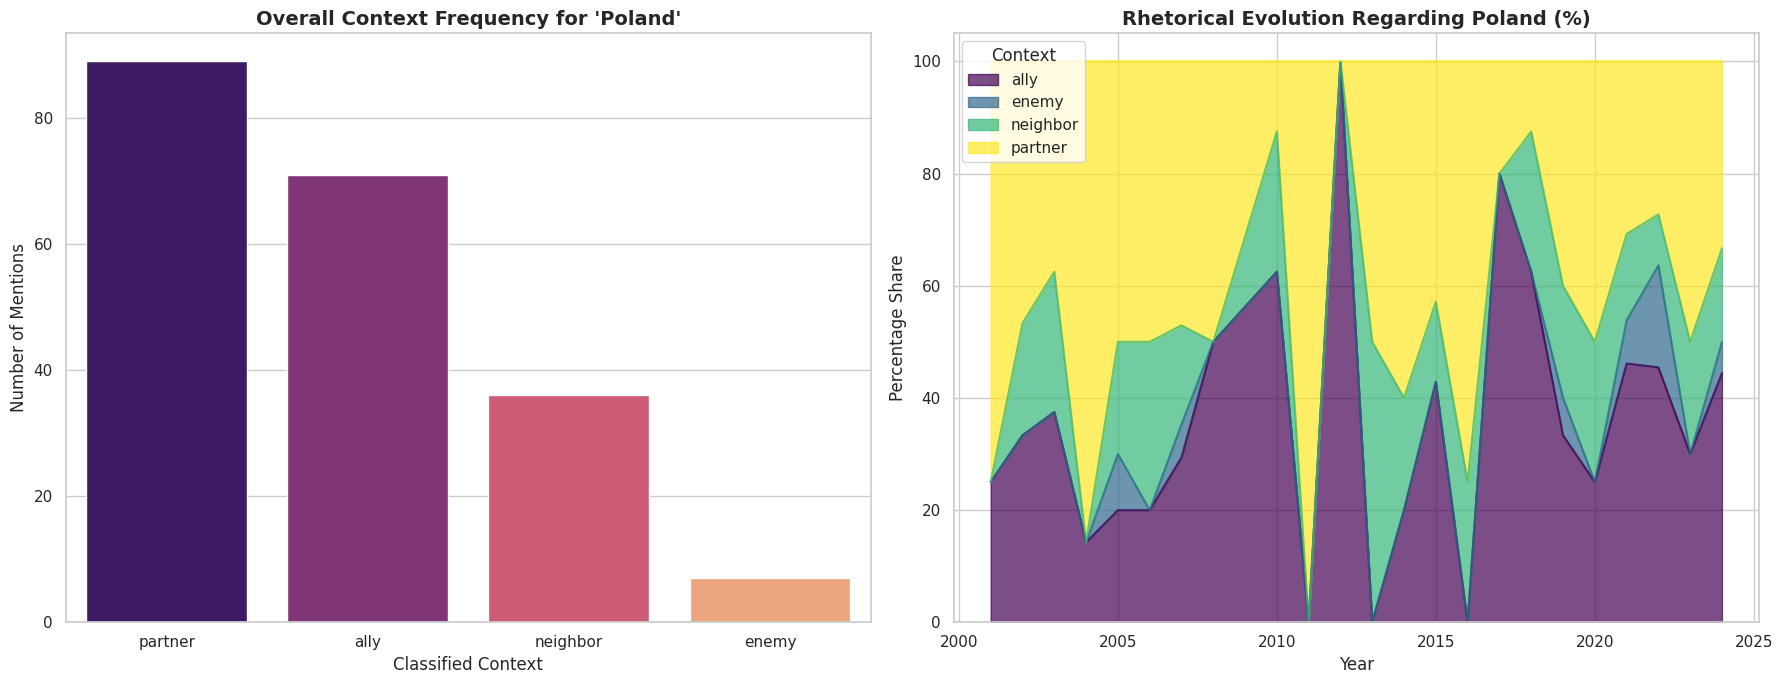


--- Summary Table (Counts per Year) ---
context  ally  enemy  neighbor  partner
year                                   
2015        3      0         1        3
2016        0      0         2        6
2017        4      0         0        1
2018        5      0         2        1
2019        5      1         3        6
2020        1      0         1        2
2021        6      1         2        4
2022        5      2         1        3
2023        3      0         2        5
2024        8      1         3        6


In [10]:
import os
import json
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline

# ---------------------------------------------------------
# CONFIGURATION
# ---------------------------------------------------------
BASE_PATH = "corpus_data/data/institution/ru-putin-speeches"
TARGET_SPEAKERS = {"PRESIDENT PUTIN", "VLADIMIR PUTIN"}
# Using BART Large for high-quality zero-shot classification
CLASSIFIER_MODEL = "facebook/bart-large-mnli"
CANDIDATE_LABELS = ["enemy", "partner", "ally", "neighbor"]

# ---------------------------------------------------------
# STEP 1: LOAD AND FILTER DATA
# ---------------------------------------------------------
corpus_data = []
print("--- Loading and filtering corpus data ---")

for root, dirs, files in os.walk(BASE_PATH):
    for file in files:
        if file.endswith(".json"):
            try:
                with open(os.path.join(root, file), encoding="utf-8") as f:
                    data = json.load(f)

                doc_date = data.get("date_iso")
                structured_content = data.get("structured_content", [])

                for block in structured_content:
                    if block.get("speaker") in TARGET_SPEAKERS:
                        text = block.get("text") or block.get("content")
                        if text:
                            corpus_data.append({
                                "text": text.strip(),
                                "date": doc_date,
                                "year": pd.to_datetime(doc_date).year if doc_date else None
                            })
            except Exception as e:
                continue

df = pd.DataFrame(corpus_data)
print(f"Total speeches collected: {len(df)}")

# ---------------------------------------------------------
# STEP 2: EXTRACT CONTEXT RELATING TO POLAND
# ---------------------------------------------------------
print("\n--- Filtering mentions of 'Poland' or 'Polish' ---")
# We filter first to save massive amounts of computation time
poland_df = df[df['text'].str.contains(r'\bPol(and|ish)\b', case=False, regex=True)].copy()
print(f"Mentions found: {len(poland_df)}")

# ---------------------------------------------------------
# STEP 3: NLP CLASSIFICATION (Zero-Shot)
# ---------------------------------------------------------
print(f"\n--- Initializing NLP Classifier ({CLASSIFIER_MODEL}) ---")
device = 0 if torch.cuda.is_available() else -1
classifier = pipeline("zero-shot-classification", model=CLASSIFIER_MODEL, device=device)

def classify_text(text):
    # Truncate text to fit model max length (approx 512 tokens)
    result = classifier(text[:1024], CANDIDATE_LABELS)
    return result['labels'][0]

print("Classifying contexts... (this may take a few minutes)")
poland_df['context'] = poland_df['text'].apply(classify_text)

# ---------------------------------------------------------
# STEP 4: VISUALIZATION
# ---------------------------------------------------------
print("\n--- Generating Visualizations ---")
sns.set_theme(style="whitegrid")

# Create a 1x2 subplot layout
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Plot A: Overall Distribution
counts = poland_df['context'].value_counts()
sns.barplot(x=counts.index, y=counts.values, palette="magma", ax=ax1)
ax1.set_title("Overall Context Frequency for 'Poland'", fontsize=14, fontweight='bold')
ax1.set_ylabel("Number of Mentions")
ax1.set_xlabel("Classified Context")

# Plot B: Evolution over Time (Percentage Share)
timeline = poland_df.groupby(['year', 'context']).size().unstack(fill_value=0)
# Normalize to 100% for each year to see shift in rhetoric
timeline_perc = timeline.divide(timeline.sum(axis=1), axis=0) * 100

timeline_perc.plot(kind='area', stacked=True, ax=ax2, alpha=0.7, colormap="viridis")
ax2.set_title("Rhetorical Evolution Regarding Poland (%)", fontsize=14, fontweight='bold')
ax2.set_ylabel("Percentage Share")
ax2.set_xlabel("Year")
ax2.legend(title="Context", loc='upper left')

plt.tight_layout()
plt.show()

# Print Summary Table
print("\n--- Summary Table (Counts per Year) ---")
print(timeline.tail(10))

# Rusky Mir analyze

Loading NER model...


config.json:   0%|          | 0.00/998 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Device set to use cpu
/tmp/ipython-input-1682972104.py:21: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = dataframe['text'].str.contains(target_pattern, case=False, na=False, regex=True)


Searching for 'Russian World' references...


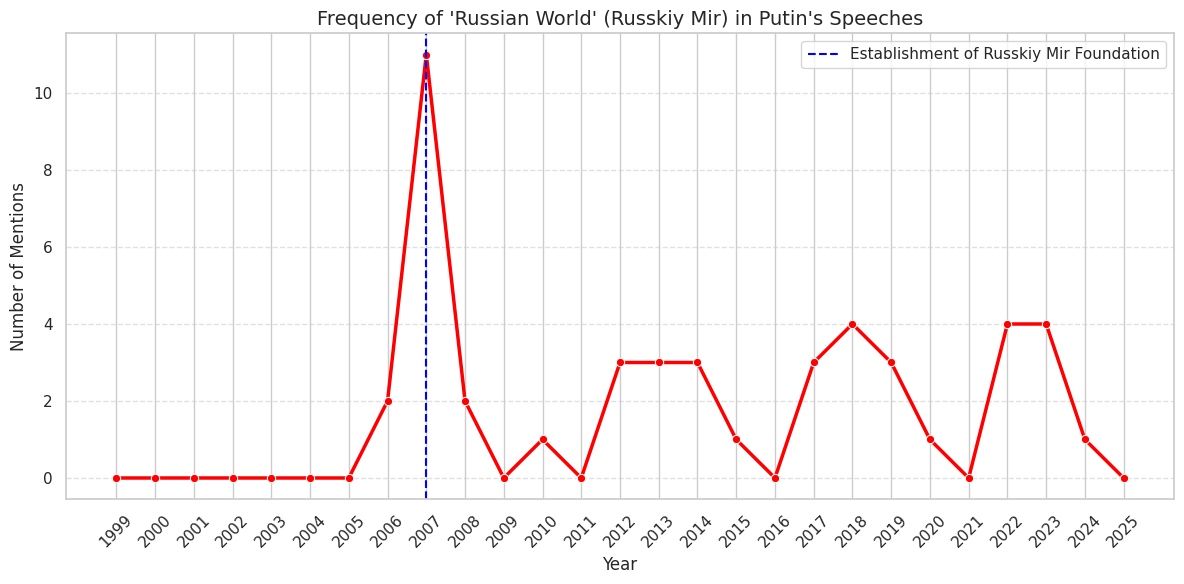


--- Sample NER Contexts ---
   year                                           entities
0  2010  Russia (LOC), Teacher (MISC), Russkiy Mir (MIS...
1  2023  United States (LOC), Russian Federation (LOC),...
2  2023  Russia (LOC), Armed Forces (ORG), Russia (LOC)...
3  2018  22nd (MISC), World Russian People ’ s Council ...
4  2017  Fund (ORG), Russian (MISC), Russian (MISC), Ru...
5  2014  Lugansk (LOC), Ukrainian (MISC), Russian (MISC...
6  2018  6th World Congress (MISC), of (ORG), Co (MISC)...
7  2019  Russian (MISC), Russian (MISC), Russian (MISC)...
8  2018  Kaliningrad Region (LOC), Russian (MISC), Russ...
9  2007  Faceted Palace (LOC), Moscow Kremlin (LOC), Ac...


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
import re

# 1. Initialize NER Pipeline (Using a fast, accurate transformer model)
print("Loading NER model...")
ner_executor = pipeline("ner", model="dbmdz/bert-large-cased-finetuned-conll03-english",
                        aggregation_strategy="simple", device=-1) # Set device=0 for GPU

# 2. Define the target phrase
# We look for "Russian world" and "Russkiy mir" (transliterated)
target_pattern = r"\b(Russian world|Russkiy mir|Russian-speaking world)\b"

def analyze_russkiy_mir(dataframe):
    results = []

    print("Searching for 'Russian World' references...")
    # Filter only rows containing the pattern
    mask = dataframe['text'].str.contains(target_pattern, case=False, na=False, regex=True)
    matches = dataframe[mask].copy()

    for _, row in matches.iterrows():
        text = row['text']
        # Extract entities from the paragraph where the term appears
        # We limit text length to fit model constraints
        entities = ner_executor(text[:1024])
        entity_list = [f"{e['word']} ({e['entity_group']})" for e in entities]

        results.append({
            "year": row['year'],
            "date": row['date'],
            "entities": ", ".join(entity_list)
        })

    return pd.DataFrame(results)

# 3. Run Analysis
rm_df = analyze_russkiy_mir(df) # Using 'df' from your previous preprocessing

# 4. Visualization: Frequency Over Time
if not rm_df.empty:
    plt.figure(figsize=(12, 6))
    yearly_counts = rm_df.groupby('year').size().reindex(
        range(int(df['year'].min()), int(df['year'].max()) + 1), fill_value=0
    )

    sns.lineplot(x=yearly_counts.index, y=yearly_counts.values, marker='o', color='red', linewidth=2.5)

    plt.title("Frequency of 'Russian World' (Russkiy Mir) in Putin's Speeches", fontsize=14)
    plt.ylabel("Number of Mentions")
    plt.xlabel("Year")
    plt.xticks(yearly_counts.index, rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    plt.axvline(x=2007, color='blue', linestyle='--', label='Establishment of Russkiy Mir Foundation')
    plt.legend()

    plt.tight_layout()
    plt.show()

    print("\n--- Sample NER Contexts ---")
    print(rm_df[['year', 'entities']].head(10))
else:
    print("No references to 'Russian world' found in the dataset.")

# Clusters of enemy creation

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.
/tmp/ipython-input-3936468306.py:12: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  enemy_df = df[df['text'].str.contains(hostile_keywords, case=False, regex=True)].copy()


Analyzing 2189 sentences related to 'enemy' construction...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/69 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


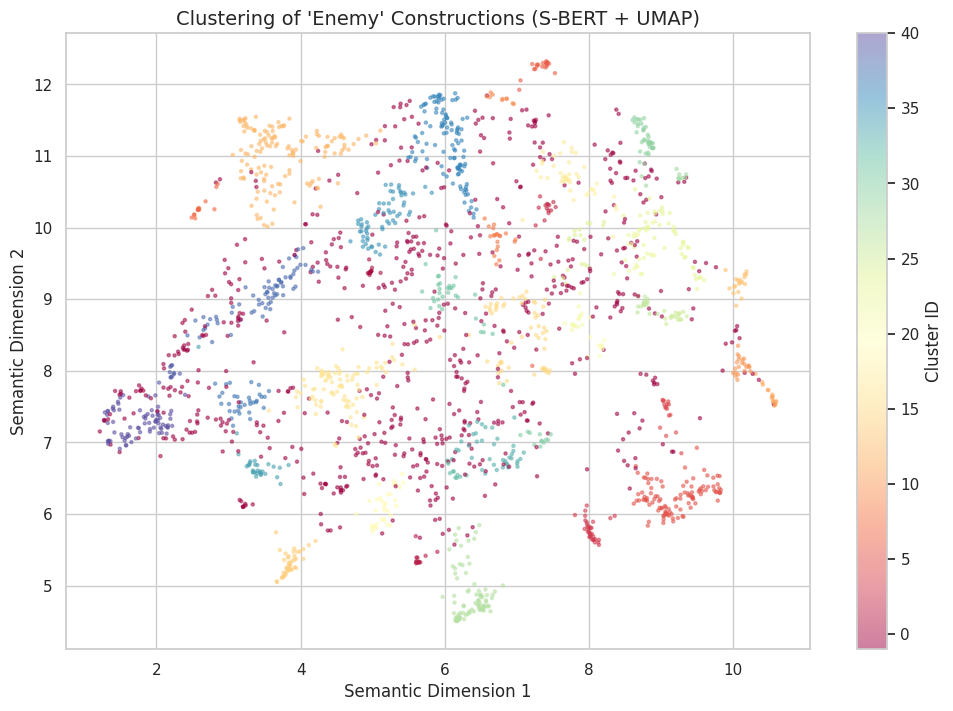


--- Identified 'Enemy' Images ---
Cluster 0 (Themes): north, korea, missile, nuclear, think, korean, security, country, russia, states
Cluster 1 (Themes): georgia, georgian, russia, people, russian, international, relations, terrorists, south, problems
Cluster 2 (Themes): russia, belarus, countries, cis, like, russian, state, belarusian, cooperation, year
Cluster 3 (Themes): russia, israel, middle, east, people, palestinian, israeli, russian, world, situation
Cluster 4 (Themes): turkey, turkish, russia, know, people, russian, relations, terrorist, nato, time
Cluster 5 (Themes): syria, syrian, russia, president, terrorist, international, countries, people, work, political
Cluster 6 (Themes): italian, russia, italy, russian, cooperation, relations, international, today, minister, prime
Cluster 7 (Themes): crimea, people, russia, sevastopol, ukraine, russian, like, crimean, today, work
Cluster 8 (Themes): russia, french, france, russian, international, president, security, like, cooperat

In [12]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
import umap
import hdbscan
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

# 1. Filter sentences that contain "enemy" or hostile references
# We expand the filter to capture the 'construction' of the enemy
hostile_keywords = r"\b(enemy|threat|aggressor|adversary|hostile|terrorist|neo-nazi|west|nato)\b"
enemy_df = df[df['text'].str.contains(hostile_keywords, case=False, regex=True)].copy()

print(f"Analyzing {len(enemy_df)} sentences related to 'enemy' construction...")

# 2. Generate Embeddings using S-BERT
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(enemy_df['text'].tolist(), show_progress_bar=True)

# 3. Dimensionality Reduction (UMAP)
# This prepares data for clustering by bringing similar meanings closer together
reducer = umap.UMAP(n_neighbors=15, n_components=5, metric='cosine', random_state=42)
reduced_embeddings = reducer.fit_transform(embeddings)

# 4. Clustering (HDBSCAN)
clusterer = hdbscan.HDBSCAN(min_cluster_size=10, metric='euclidean', cluster_selection_method='eom')
enemy_df['cluster'] = clusterer.fit_predict(reduced_embeddings)

# 5. Identifying the "Images" of the enemy
def get_topic_keywords(df, cluster_id, n_words=10):
    docs = df[df['cluster'] == cluster_id]['text'].str.cat(sep=' ')
    vectorizer = CountVectorizer(stop_words='english')
    X = vectorizer.fit_transform([docs])
    words = vectorizer.get_feature_names_out()
    counts = X.toarray().flatten()
    return [words[i] for i in counts.argsort()[-n_words:][::-1]]

# 6. Visualization
plt.figure(figsize=(12, 8))
# Projecting to 2D for plotting
vis_reducer = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.1, metric='cosine', random_state=42)
vis_coords = vis_reducer.fit_transform(embeddings)

scatter = plt.scatter(vis_coords[:, 0], vis_coords[:, 1], c=enemy_df['cluster'], cmap='Spectral', s=5, alpha=0.5)
plt.colorbar(scatter, label='Cluster ID')
plt.title("Clustering of 'Enemy' Constructions (S-BERT + UMAP)", fontsize=14)
plt.xlabel("Semantic Dimension 1")
plt.ylabel("Semantic Dimension 2")
plt.show()

# Print the themes found
print("\n--- Identified 'Enemy' Images ---")
for cluster in set(enemy_df['cluster']):
    if cluster == -1: continue # Skip noise
    keywords = get_topic_keywords(enemy_df, cluster)
    print(f"Cluster {cluster} (Themes): {', '.join(keywords)}")

### Top 5 clusters

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



--- TOP 5 IMAGES OF THE 'ENEMY' ---
Image 1 (Cluster 12): ukraine, ukrainian, like, country, nato, military, know, just
Image 2 (Cluster 36): nato, security, relations, countries, think, europe, states, military
Image 3 (Cluster 5): syria, syrian, terrorist, international, countries, work, political, country
Image 4 (Cluster 16): state, country, work, need, development, new, like, important
Image 5 (Cluster 27): chechnya, chechen, republic, terrorist, like, know, terrorists, situation


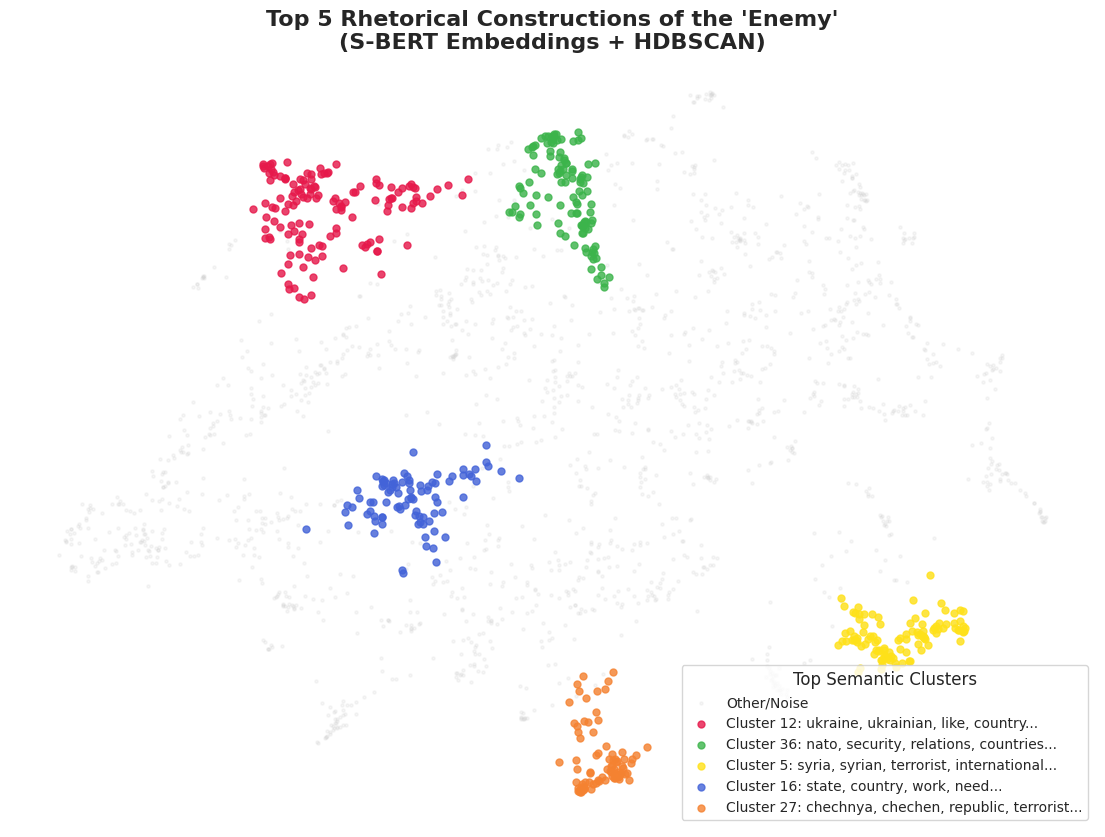

In [19]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
import umap
import hdbscan
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

# --- 1. PREPARATION (Assumes 'enemy_df' and 'embeddings' exist from previous step) ---

# --- 2. RANK CLUSTERS BY SIZE ---
# We count how many sentences belong to each cluster and pick the Top 5
cluster_counts = enemy_df['cluster'].value_counts()
# We exclude -1 (which HDBSCAN uses for noise)
top_5_clusters = cluster_counts[cluster_counts.index != -1].head(5).index.tolist()

# --- 3. ENHANCED KEYWORD EXTRACTION ---
def get_clean_keywords(df, cluster_id, n_words=8):
    # Custom stop words to remove rhetorical noise common in transcripts
    custom_stops = ['said', 'mr', 'vladimir', 'putin', 'president', 'russia', 'russian', 'people']
    docs = df[df['cluster'] == cluster_id]['text'].str.cat(sep=' ')

    vectorizer = CountVectorizer(stop_words='english')
    X = vectorizer.fit_transform([docs])
    words = vectorizer.get_feature_names_out()
    counts = X.toarray().flatten()

    # Filter out custom stops and get top N
    word_freq = [(words[i], counts[i]) for i in range(len(words)) if words[i] not in custom_stops]
    word_freq = sorted(word_freq, key=lambda x: x[1], reverse=True)
    return [word[0] for word in word_freq[:n_words]]

# --- 4. VISUALIZATION OF TOP 5 ---
plt.figure(figsize=(14, 10))

# 2D Projection for the plot
vis_reducer = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.1, metric='cosine', random_state=42)
vis_coords = vis_reducer.fit_transform(embeddings)

# Plot Background (Noise in light grey)
plt.scatter(vis_coords[:, 0], vis_coords[:, 1], c='lightgrey', s=5, alpha=0.2, label='Other/Noise')

# Plot Top 5 Clusters with distinct colors
colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231']
print("\n--- TOP 5 IMAGES OF THE 'ENEMY' ---")

for i, cluster_id in enumerate(top_5_clusters):
    mask = enemy_df['cluster'] == cluster_id
    keywords = get_clean_keywords(enemy_df, cluster_id)
    label_text = f"Cluster {cluster_id}: {', '.join(keywords[:4])}..."

    plt.scatter(vis_coords[mask, 0], vis_coords[mask, 1],
                c=colors[i], s=25, alpha=0.8, label=label_text)

    print(f"Image {i+1} (Cluster {cluster_id}): {', '.join(keywords)}")

plt.legend(loc='best', title="Top Semantic Clusters", fontsize=10)
plt.title("Top 5 Rhetorical Constructions of the 'Enemy'\n(S-BERT Embeddings + HDBSCAN)", fontsize=16, fontweight='bold')
plt.axis('off')
plt.show()

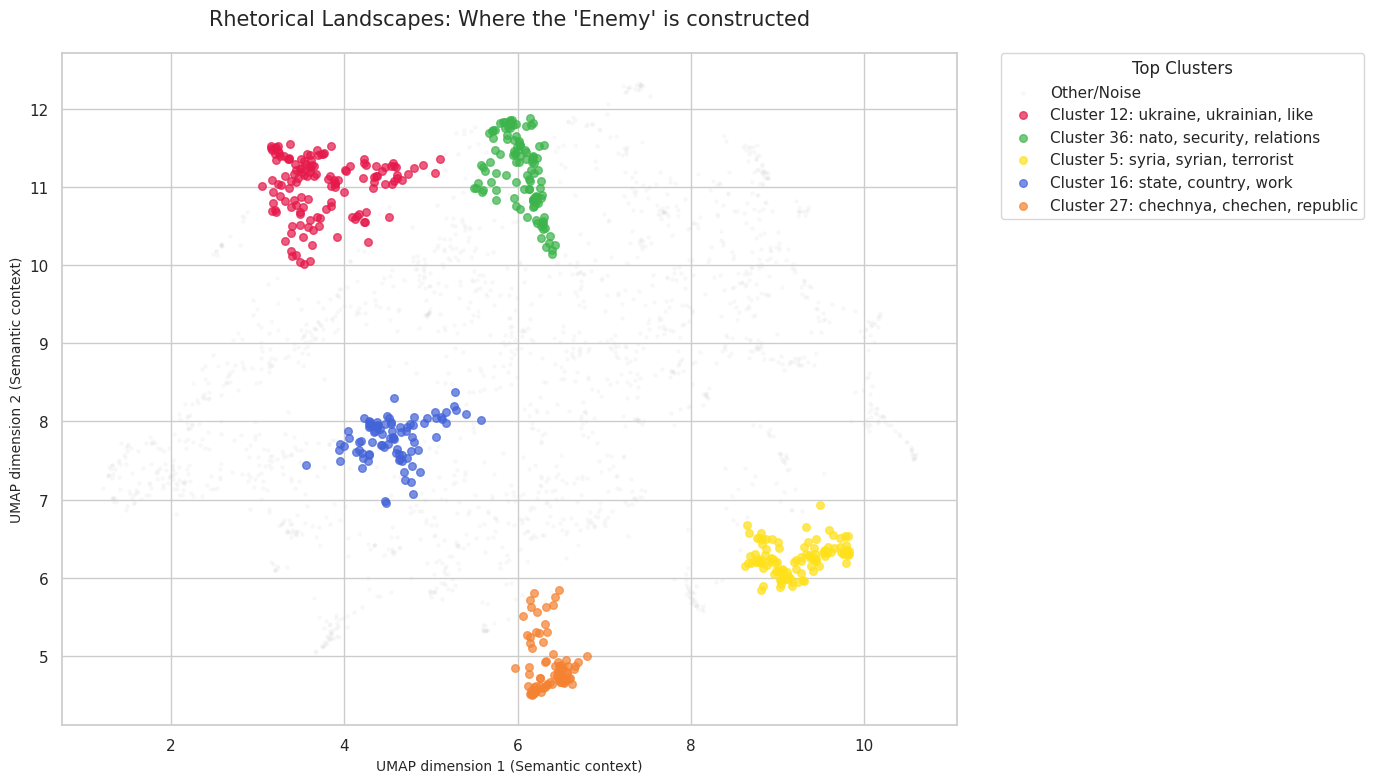

In [20]:
plt.figure(figsize=(14, 8))

plt.scatter(vis_coords[:, 0], vis_coords[:, 1], c='lightgrey', s=5, alpha=0.1, label='Other/Noise')
colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231']
for i, cluster_id in enumerate(top_5_clusters):
    mask = enemy_df['cluster'] == cluster_id
    keywords = get_clean_keywords(enemy_df, cluster_id)
    plt.scatter(vis_coords[mask, 0], vis_coords[mask, 1],
                c=colors[i], s=30, alpha=0.7,
                label=f"Cluster {cluster_id}: {', '.join(keywords[:3])}")

plt.xlabel("UMAP dimension 1 (Semantic context)", fontsize=10)
plt.ylabel("UMAP dimension 2 (Semantic context)", fontsize=10)
plt.title("Rhetorical Landscapes: Where the 'Enemy' is constructed", fontsize=15, pad=20)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title="Top Clusters")

plt.tight_layout()
plt.show()

In [26]:
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 21.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [29]:
# Check which top clusters Poland belongs to

poland_in_clusters = enemy_df[enemy_df['text'].str.contains("Poland|Polish", case=False)]['cluster'].value_counts()

print("\nPoland's presence in Top Enemy Clusters:")

print(poland_in_clusters)


Poland's presence in Top Enemy Clusters:
cluster
-1     25
 12    18
 35     8
 16     7
 36     5
 15     3
 40     3
 38     3
 29     2
 37     2
 17     2
 8      1
 2      1
 5      1
 31     1
 22     1
Name: count, dtype: int64


/tmp/ipython-input-671468865.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(stats.values()), y=list(stats.keys()), palette="Reds_r")


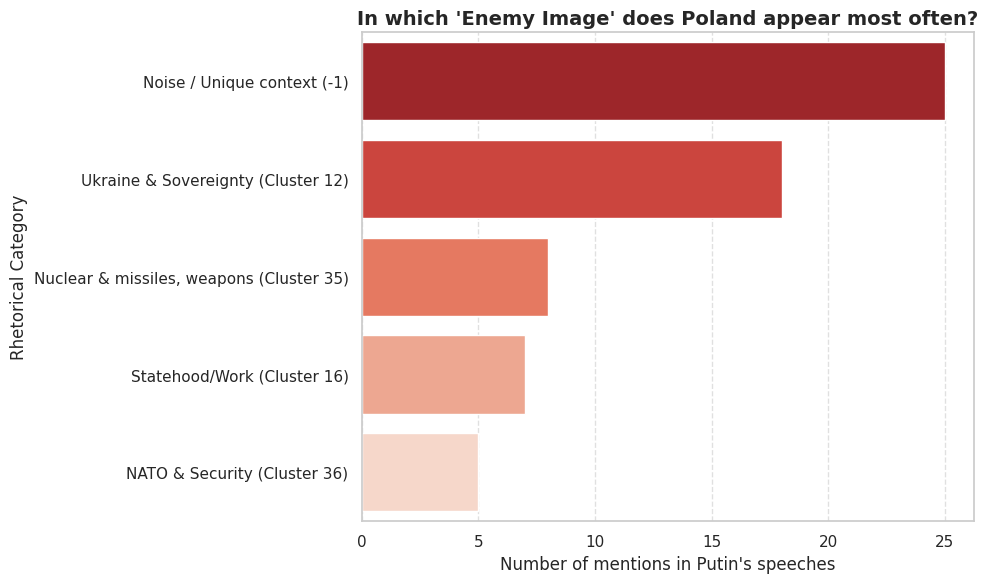

In [27]:
# Data above filtered to clusters
stats = {
    "Noise / Unique context (-1)": 25,
    "Ukraine & Sovereignty (Cluster 12)": 18,
    "Nuclear & missiles, weapons (Cluster 35)": 8,
    "Statehood/Work (Cluster 16)": 7,
    "NATO & Security (Cluster 36)": 5
}

plt.figure(figsize=(10, 6))
sns.barplot(x=list(stats.values()), y=list(stats.keys()), palette="Reds_r")

plt.title("In which 'Enemy Image' does Poland appear most often?", fontsize=14, fontweight='bold')
plt.xlabel("Number of mentions in Putin's speeches")
plt.ylabel("Rhetorical Category")

plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [22]:
# Wyświetl 5 przykładowych cytatów, gdzie Polska jest w Klastrze 12
sample_quotes = enemy_df[(enemy_df['cluster'] == 12) &
                         (enemy_df['text'].str.contains("Poland", case=False))]['text'].head(5)

print("--- Quotes placing Poland in the 'Ukraine context' (Cluster 12) ---")
for q in sample_quotes:
    print(f"> {q[:200]}...") # Drukujemy pierwsze 200 znaków

--- Quotes placing Poland in the 'Ukraine context' (Cluster 12) ---
> Good afternoon, Members of the Federation Assembly – senators, State Duma deputies, Citizens of Russia, This Presidential Address comes, as we all know, at a difficult, watershed period for our countr...
> During the recent Direct Line, when I was asked about Russian-Ukrainian relations, I said that Russians and Ukrainians were one people – a single whole. These words were not driven by some short-term ...
> We have never refused to negotiate. Dmitry Kiselev: But is there a compromise without goodwill gestures? How can it be achieved then? Vladimir Putin: Let me try to explain that. I have already said th...
> Yes. We should elaborate on what Mr Naryshkin has just said. This information has already appeared in the European media, in particular, the French. I believe it would be suitable in this context to a...
> This is a question designed to provoke. Russia pursues a peaceful foreign policy but it has the right to e

In [28]:
import spacy
import pandas as pd
import re

# 1. Load spaCy model (English)
# Note: Ensure you have run 'python -m spacy download en_core_web_md'
nlp = spacy.load("en_core_web_md")

# 2. Define historical keywords
hist_keywords = [
    "history", "century", "war", "soviet", "empire", "partition",
    "agreement", "treaty", "tsar", "stalin", "churchill", "1939",
    "1945", "ancient", "past", "ussr", "partitioned"
]

def extract_historical_quotes(dataframe):
    quotes = []

    # Pre-filter for Poland/Polish to save time
    subset = dataframe[dataframe['text'].str.contains(r"\bPol(and|ish)\b", case=False, regex=True)]

    for _, row in subset.iterrows():
        doc = nlp(row['text'])

        for i, sent in enumerate(doc.sents):
            sent_text = sent.text.strip()

            # Check if sentence mentions Poland
            if re.search(r"\bPol(and|ish)\b", sent_text, re.I):

                # Check for historical markers (NER or Keywords)
                contains_date = any(ent.label_ in ["DATE", "EVENT"] for ent in sent.ents)
                contains_hist_word = any(word in sent_text.lower() for word in hist_keywords)

                if contains_date or contains_hist_word:
                    # Get context (previous and next sentence if they exist)
                    start = max(0, i-1)
                    end = i+2
                    context = " ".join([s.text for s in list(doc.sents)[start:end]])

                    quotes.append({
                        "year": row['year'],
                        "quote": context,
                        "primary_sentence": sent_text
                    })

    return pd.DataFrame(quotes)

# 3. Run and Display
hist_df = extract_historical_quotes(df)

print(f"Found {len(hist_df)} historical quotes about Poland.\n")

# Display a few examples
for idx, row in hist_df.head(5).iterrows():
    print(f"--- Quote ({row['year']}) ---")
    print(f"{row['quote']}\n")

/tmp/ipython-input-1321505467.py:20: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  subset = dataframe[dataframe['text'].str.contains(r"\bPol(and|ish)\b", case=False, regex=True)]


Found 189 historical quotes about Poland.

--- Quote (2023) ---
People who are knowledgeable about history at least to some extent realise that this project dates back to the 19th century. The Austro-Hungarian Empire and Poland had conceived it for one purpose, that is, to deprive Russia of these historical territories that are now called Ukraine. This is their goal.

--- Quote (2016) ---
However, the statement that you are referring to was made by a high-level government official, and the company that purchases our gas is run by the state, so we believe that this is possible. Gazprom, as Chairman of the Board of Gazprom Mr Miller told me yesterday, is exploring possibilities and plans to make an offer, in the near future, to other prospective partners (Polish, European, or any other for that matter) to buy this gas from us at the Belarusian-Polish border after the contract with Poland expires, by signing a new contract for 10–15 years. These could be Polish, German, Austrian, Italian,

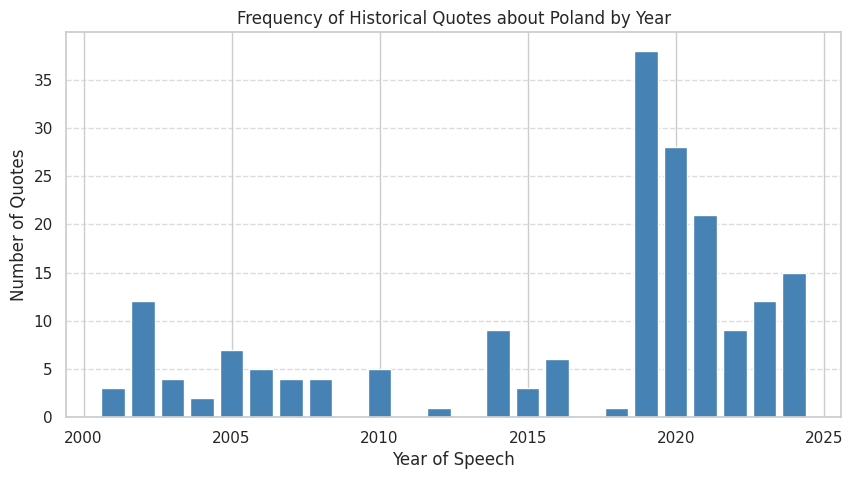

In [30]:
import matplotlib.pyplot as plt

years = hist_df['year'].value_counts().sort_index()

plt.figure(figsize=(10, 5))
plt.bar(years.index, years.values, color='steelblue')
plt.title('Frequency of Historical Quotes about Poland by Year')
plt.xlabel('Year of Speech')
plt.ylabel('Number of Quotes')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Critical Tests

/tmp/ipython-input-3312114982.py:16: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  regex_hits_mask = df['text'].str.contains(nuclear_pattern, case=False, regex=True)
/tmp/ipython-input-3312114982.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pd.DataFrame(comparison_data), x='Method', y='Hits', palette='magma', ax=axes[0])


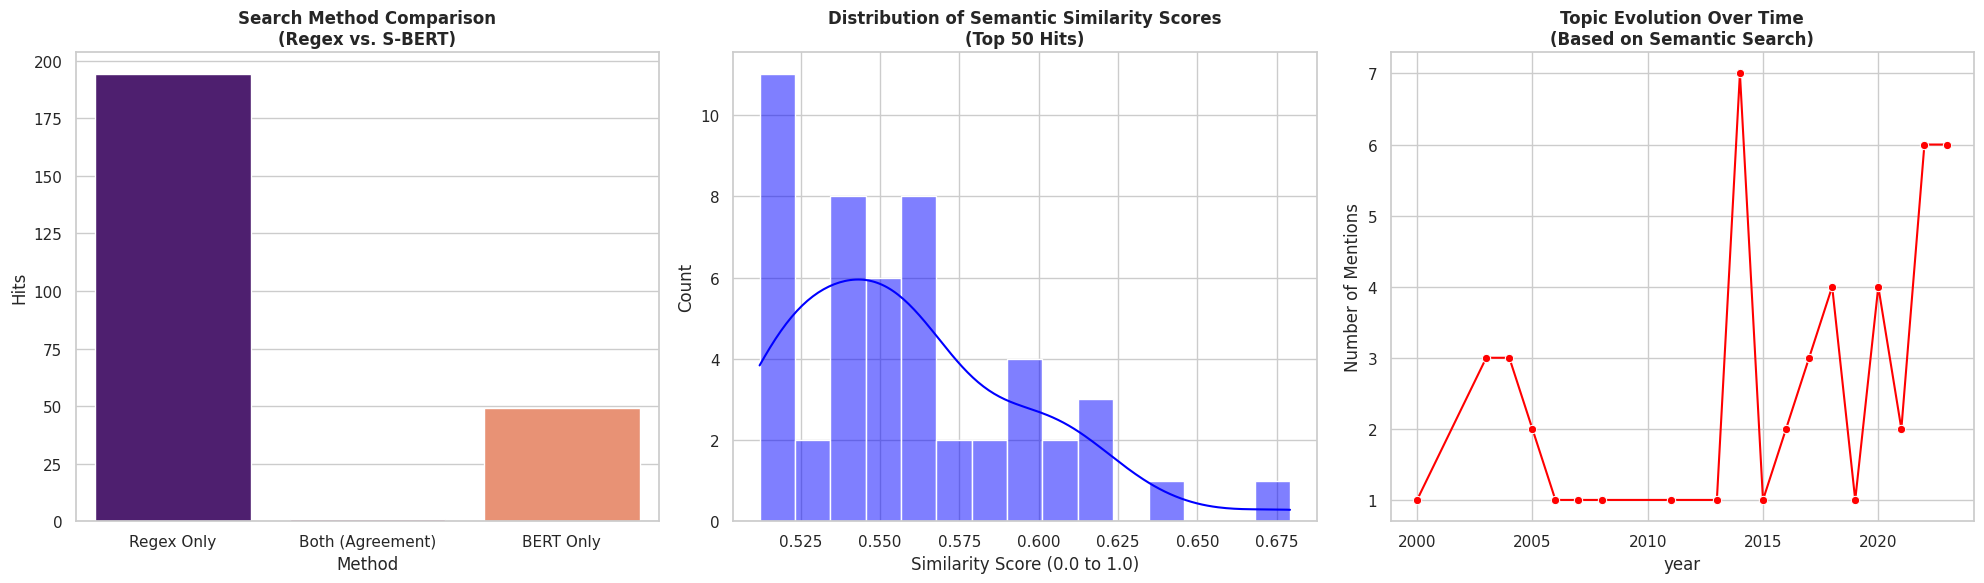


--- Top 5 'Hidden' Mentions (Found by BERT, missed by Regex) ---
[2022] (Score: 0.520): Do you mean that, in their opinion, the provision reading “during dialogue and by agreement” does not mean direct dialogue?...
[2020] (Score: 0.679): By the way, in June this year I instructed the Government, Russian Railways and Rosatom to formulate proposals and take measures to minimise the cost of fish deliveries from the Far East to European R...
[2000] (Score: 0.518): Good afternoon. I very much wanted to meet the people of Dagestan before this year was out. Last year I was in Dagestan over the New Year holiday. This time around I don’t think I can make it, so I ha...
[2003] (Score: 0.541): I am not in a position to assess these plans of the Education Ministry. But as far as I know there are actually three and not two categories of higher education institutions: federal, federal-regional...
[2020] (Score: 0.570): Citizens of Russia, A monument to the hundreds of thousands of Soviet soldiers w

In [33]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer, util

# 1. SETUP SEARCH PARAMETERS
# Keywords for the "direct" search
nuclear_pattern = r"\b(nuclear world|nuclear war|atomic weapons|nuclear weapons|nuclear strike)\b"
# Semantic description for BERT search
semantic_query = "The threat of nuclear war, global nuclear security, and the use of atomic weapons in international relations."

# 2. EXECUTE SEARCHES
# A. Regex Search
regex_hits_mask = df['text'].str.contains(nuclear_pattern, case=False, regex=True)
regex_indices = set(df[regex_hits_mask].index)

# B. BERT Search (Semantic)
model = SentenceTransformer('all-MiniLM-L6-v2')
query_embedding = model.encode(semantic_query)
# Assuming 'embeddings' (all speech vectors) were pre-calculated
cos_scores = util.cos_sim(query_embedding, embeddings)[0]
# We take the top 50 matches
top_k = 50
top_results = torch.topk(cos_scores, k=top_k)
bert_indices = set(top_results.indices.numpy())
bert_scores = top_results.values.numpy()

# 3. VISUALIZATION
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# CHART 1: Comparison of Methods (The "Critical Test" Outcome)
common = len(regex_indices.intersection(bert_indices))
regex_only = len(regex_indices - bert_indices)
bert_only = len(bert_indices - regex_indices)

comparison_data = {
    'Method': ['Regex Only', 'Both (Agreement)', 'BERT Only'],
    'Hits': [regex_only, common, bert_only]
}
sns.barplot(data=pd.DataFrame(comparison_data), x='Method', y='Hits', palette='magma', ax=axes[0])
axes[0].set_title("Search Method Comparison\n(Regex vs. S-BERT)", fontweight='bold')

# CHART 2: BERT Similarity Scores (Quality of matches)
sns.histplot(bert_scores, bins=15, kde=True, color='blue', ax=axes[1])
axes[1].set_title("Distribution of Semantic Similarity Scores\n(Top 50 Hits)", fontweight='bold')
axes[1].set_xlabel("Similarity Score (0.0 to 1.0)")

# CHART 3: Timeline of the Topic (Using BERT results)
bert_hits_df = df.iloc[list(bert_indices)].copy()
timeline = bert_hits_df.groupby('year').size()
sns.lineplot(x=timeline.index, y=timeline.values, marker='o', color='red', ax=axes[2])
axes[2].set_title("Topic Evolution Over Time\n(Based on Semantic Search)", fontweight='bold')
axes[2].set_ylabel("Number of Mentions")

plt.tight_layout()
plt.show()

# 4. PRINTING UNIQUE BERT FINDINGS
print("\n--- Top 5 'Hidden' Mentions (Found by BERT, missed by Regex) ---")
unique_bert = list(bert_indices - regex_indices)[:5]
for idx in unique_bert:
    score = cos_scores[idx].item()
    print(f"[{df.iloc[idx]['year']}] (Score: {score:.3f}): {df.iloc[idx]['text'][:200]}...")

In [32]:
print("--- BERT's Discovery (Top 10 Euphemisms?) ---")
for i in list(bert_indices)[:10]:
    print(f"Score: {cos_scores[i]:.4f} | Text: {df.iloc[i]['text'][:150]}...")

--- BERT's Discovery (Top 10 Euphemisms?) ---
Score: 0.4649 | Text: Plenary session moderator Sergei Brilyov: Mr President, what about the presence of Russia’s military and navy in this region [the Strait of Hormuz]? I...
Score: 0.5251 | Text: Colleagues, Greetings to the participants in the 11th International Meeting of High Representatives in charge of security issues. Over years, your reg...
Score: 0.4744 | Text: Dear Mr Chairman, ladies and gentlemen. First of all, I would like to stress the main result of the Russian-Chinese meeting today. This meeting can tr...
Score: 0.4474 | Text: Mr President, Emmanuel, It is a pleasure to see you. Last time we met was two years ago and, of course, there is a backlog of issues that we can and s...
Score: 0.4527 | Text: Good afternoon, colleagues. Our keynote speaker today, Mr Belousov, will talk about the development of shipping. This is a very big and important issu...
Score: 0.4786 | Text: Vladimir Putin: Of course we are forced to take this

In [ ]:
print("--- BERT's Discovery (Top 10 Euphemisms?) ---")
for i in list(bert_indices)[:10]:
    print(f"Score: {cos_scores[i]:.4f} | Text: {df.iloc[i]['text'][:150]}...")